In [1]:

import numpy as np
import pandas as pd
# Algorítimos
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, KFold
from nested_cv import NestedCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import joblib
from sklearn.metrics import accuracy_score, cohen_kappa_score, matthews_corrcoef
from scipy.stats import expon, randint, uniform
from scipy.stats import randint as sp_randint



In [2]:
from rdkit.Chem import PandasTools
from collections import Counter
## Carregar dados
def carregar_dados():
    # Definir caminho do arquivo
    file = '../dataset/formats/sdf/COVID-Sulkowsk.sdf'

       # Novo dicionário inicializado a partir de um objeto de mapeamento
    sdfInfo = dict(smilesName='SMILES', molColName='ROMol')

    # Carregando o arquivo SDF com os dicionarios mapeados
    moldf = PandasTools.LoadSDF(file, **sdfInfo)
    print('Original data: ', moldf.shape)

    # Renomear ROMol
    moldf = moldf.rename(columns={'ROMol': 'Mol'})

    # Remover moléculas RDKit ausentes
    moldf = moldf[pd.notnull(moldf['Mol'])]
    if 'StandardizerResult' in moldf.columns:
        moldf = moldf.drop(columns='StandardizerResult')

    # Colunas
    print('Dados mantidos: ', moldf.shape)


    moldf['Outcome'] = moldf['Outcome'].replace('Active', 1)
    moldf['Outcome'] = moldf['Outcome'].replace('Inactive', 0)

    classes = Counter(moldf['Outcome'])
    print('\033[1m' + 'Forma do conjunto de treinamento:' + '\n' + '\033[0m')
    for key, value in classes.items():
        print('\t\t Classe %d: %d' % (key, value))
    print('\t\t Número total de compostos: %d' % (len(moldf['Outcome'])))

    print('Class labels:', np.unique(classes))
  
    return moldf

Original data:  (2612, 4)
Dados mantidos:  (2612, 4)
Forma do conjunto de treinamento:

		 Classe 1: 950
		 Classe 0: 1662
		 Número total de compostos: 2612
Class labels: [Counter({0: 1662, 1: 950})]


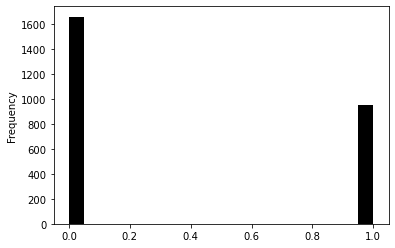

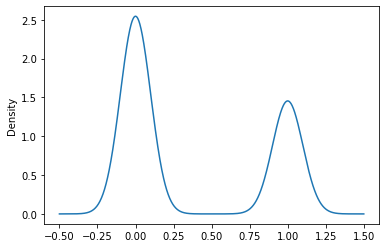

In [3]:
moldf = carregar_dados();
moldf.plot(kind="hist", legend=None, bins=20, color='k')
moldf.plot(kind="kde", legend=None);

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from math import floor
#Rdkit: coleção de quiminformática e software de aprendizado de máquina escrito em C++ e Python de Código Aberto.
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from collections import Counter
from sklearn.feature_selection import VarianceThreshold

## Carregar dados
def rdkit_descriptors(moldf):
    desc = pd.read_csv('../descriptors/generate/rdkit/rdkit_Molecule_descriptors.csv', sep=',')
    desc.drop(desc.columns[0:1], axis=1,inplace=True)
    descriptors = desc.columns.difference(moldf.columns).tolist()
    
    moldf_desc = pd.concat([moldf,desc], axis=1)
    moldf_desc['Set'] = 'train'
    moldf_train = moldf_desc[(moldf_desc['Set'] == 'train')]

    y_train = moldf_train['Outcome'].to_numpy()
    X_train = moldf_train[descriptors]
    X_train.shape
    
    data_train = {'moldf_desc': moldf_desc, 'moldf_train': moldf_train, 'Y_train': moldf_train['Outcome'].to_numpy(), 'X_train': moldf_train[descriptors]}
    return data_train
    

In [23]:
data_rdkit = rdkit_descriptors(moldf)
Y_train_rdkit = data_rdkit['Y_train']
X_train_rdkit = data_rdkit['X_train']
X_train_rdkit.shape

(2612, 208)

In [24]:
# verifique se o conjunto de dados está balanceado
sum(Y_train_rdkit) / len(Y_train_rdkit)

0.36370597243491576

In [25]:
seed = 42

#### Divida todo o conjunto em conjuntos de treinamento e teste

In [26]:
# randomly select 20% of compounds as test set
x_tr, x_ts, y_tr, y_ts = train_test_split(X_train_rdkit, Y_train_rdkit, test_size=0.20, random_state=seed)

In [27]:
cv = StratifiedKFold(n_splits=5, shuffle=False, random_state=None)

In [28]:
# print out ids of folds
for i, (train_index, test_index) in enumerate(cv.split(x_tr, y_tr)):
    print("\nFold_" + str(i+1))
    print("TRAIN:", train_index)
    print("TEST:", test_index)


Fold_1
TRAIN: [ 418  419  420 ... 2086 2087 2088]
TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 23

In [29]:
scale = StandardScaler().fit(x_tr)
x_tr = scale.transform(x_tr)

In [30]:
joblib.dump(scale, "pkl/logBB_scale_rdkit.pkl", compress=3)

['pkl/logBB_scale_rdkit.pkl']

# RANDOM FOREST

In [31]:
# create grid search dictionary
param_grid = {"max_features": [x_tr.shape[1] // 10, x_tr.shape[1] // 7, x_tr.shape[1] // 5, x_tr.shape[1] // 3], 
              "n_estimators": randint(100,1000)}

In [32]:
# setup model building
m = RandomizedSearchCV(RandomForestClassifier(), param_grid, n_jobs=2, cv=cv, verbose=1)

In [33]:
# run model building
m.fit(x_tr, y_tr)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(), n_jobs=2,
                   param_distributions={'max_features': [20, 29, 41, 69],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd6ea3e0350>},
                   verbose=1)

In [23]:
m.best_params_

{'max_features': 288, 'n_estimators': 390}

In [24]:
m.best_score_

0.9956914850894403

In [25]:
m.cv_results_

{'mean_fit_time': array([30.15657053, 17.04754677, 43.46687999, 56.18002639, 54.17975903,
        39.56079831,  9.50171299, 39.94430594, 42.41206846, 32.87366009]),
 'std_fit_time': array([1.49695651, 0.59089783, 1.8757778 , 2.49093177, 1.96661281,
        2.21309249, 0.4869552 , 1.70857234, 1.79909959, 3.41580318]),
 'mean_score_time': array([0.08891735, 0.04841266, 0.10881028, 0.12835698, 0.13014188,
        0.06702561, 0.02801995, 0.08094988, 0.11355295, 0.04876657]),
 'std_score_time': array([0.00175251, 0.00134741, 0.00111494, 0.02394309, 0.03094958,
        0.01373117, 0.00382002, 0.00258858, 0.00264694, 0.00526514]),
 'param_max_features': masked_array(data=[144, 144, 144, 206, 206, 288, 144, 206, 144, 288],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[624, 330, 782, 766, 703, 390, 177, 556, 790, 359],
              mask=

In [26]:
m.cv_results_['mean_test_score']

array([0.99521302, 0.99521302, 0.99521302, 0.99521302, 0.99521302,
       0.99569149, 0.99569149, 0.99569149, 0.99521302, 0.99569149])

In [27]:
m.cv_results_['params']

[{'max_features': 144, 'n_estimators': 624},
 {'max_features': 144, 'n_estimators': 330},
 {'max_features': 144, 'n_estimators': 782},
 {'max_features': 206, 'n_estimators': 766},
 {'max_features': 206, 'n_estimators': 703},
 {'max_features': 288, 'n_estimators': 390},
 {'max_features': 144, 'n_estimators': 177},
 {'max_features': 206, 'n_estimators': 556},
 {'max_features': 144, 'n_estimators': 790},
 {'max_features': 288, 'n_estimators': 359}]

In [28]:
joblib.dump(m, "pkl/logBB_rf_morgan.pkl", compress=3)

['pkl/logBB_rf_morgan.pkl']

In [29]:
# load scale if necessary
scale = joblib.load("pkl/logBB_scale_rdkit.pkl")

In [30]:
# scale descriptors of the test set compounds
x_ts = scale.transform(x_ts)

In [31]:
# predict logBB class
pred_rf = m.predict(x_ts)

In [32]:
pred_rf

array([0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,

In [53]:
# calc statistics
print("Accuracy = ", accuracy_score(y_ts, pred_rf))
print("MCC = ", matthews_corrcoef(y_ts, pred_rf))
print("Kappa = ", cohen_kappa_score(y_ts, pred_rf))

Accuracy =  1.0
MCC =  1.0
Kappa =  1.0


In [ ]:
# estimate applicability domain and calc stat
pred_prob = svm.predict_proba(x_ts)

In [37]:
pred_prob

array([[1.        , 0.        ],
       [0.01282051, 0.98717949],
       [0.        , 1.        ],
       ...,
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ]])

In [38]:
# limiar
threshold = 0.8

In [39]:
# calcule a probabilidade máxima prevista para cada linha (composto) e compare com o limite
da = np.amax(pred_prob, axis=1) > threshold

In [40]:
# calc statistics
accuracy_score(np.asarray(y_ts)[da], pred_rf[da])

1.0

In [41]:
matthews_corrcoef(np.asarray(y_ts)[da], pred_rf[da])

1.0

In [42]:
cohen_kappa_score(np.asarray(y_ts)[da], pred_rf[da])

1.0

In [43]:
# calc coverage
sum(da) / len(da)

0.9961759082217974

# SVM

In [44]:
# create grid search dictionary
param_grid = {"C": [10 ** i for i in range(0, 5)],
              "gamma": [10 ** i for i in range(-6, 0)]}

In [45]:
# setup model building
svm = RandomizedSearchCV(SVC(kernel='rbf', probability=True), param_grid, n_jobs=2, cv=cv, verbose=1)

In [46]:
# run model building
svm.fit(x_tr, y_tr)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=SVC(probability=True), n_jobs=2,
                   param_distributions={'C': [1, 10, 100, 1000, 10000],
                                        'gamma': [1e-06, 1e-05, 0.0001, 0.001,
                                                  0.01, 0.1]},
                   verbose=1)

In [47]:
svm.best_score_

0.9966495702959165

In [48]:
svm.best_params_

{'gamma': 1e-05, 'C': 1000}

In [49]:
joblib.dump(svm, "pkl/logBB_svm_morgan.pkl", compress=3)

['pkl/logBB_svm_morgan.pkl']

In [50]:
# predict logBB for the test set compounds
pred_svm = svm.predict(x_ts)

In [51]:
pred_svm

array([0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,

In [52]:
# calc statistics
print("Accuracy = ", accuracy_score(y_ts, pred_svm))
print("MCC = ", matthews_corrcoef(y_ts, pred_svm))
print("Kappa = ", cohen_kappa_score(y_ts, pred_svm))

Accuracy =  0.9980879541108987
MCC =  0.9959861233185617
Kappa =  0.9959780677807085


In [54]:
# estimate applicability domain and calc stat
pred_prob = svm.predict_proba(x_ts)

In [55]:
da = np.amax(pred_prob, axis=1) > threshold

In [56]:
print("Accuracy = ", accuracy_score(np.asarray(y_ts)[da], pred_svm[da]))
print("MCC = ", matthews_corrcoef(np.asarray(y_ts)[da], pred_svm[da]))
print("Kappa = ", cohen_kappa_score(np.asarray(y_ts)[da], pred_svm[da]))
print("Coverage = ", sum(da) / len(da))

Accuracy =  1.0
MCC =  1.0
Kappa =  1.0
Coverage =  0.9961759082217974


# MULTILAYER PERCEPTRON

In [57]:
param_grid = {
    'hidden_layer_sizes': [(sp_randint.rvs(100,600,1),sp_randint.rvs(100,600,1),), 
                                          (sp_randint.rvs(100,600,1),)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': uniform(0.0001, 0.9),
    'learning_rate': ['constant','adaptive']}

In [58]:
mlp = RandomizedSearchCV(MLPClassifier(), param_grid, n_jobs=2, cv=cv, verbose=1)

In [59]:
# run model building
mlp.fit(x_tr, y_tr)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=MLPClassifier(), n_jobs=2,
                   param_distributions={'activation': ['tanh', 'relu',
                                                       'logistic'],
                                        'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa29c46b210>,
                                        'hidden_layer_sizes': [(357, 187),
                                                               (262,)],
                                        'learning_rate': ['constant',
                                                          'adaptive'],
                                        'solver': ['sgd', 'adam', 'lbfgs']},
                   verbose=1)

In [60]:
mlp.best_score_

0.9976065080949595

/home/note/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/note/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/note/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/note/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

In [61]:
mlp.best_params_

{'activation': 'tanh',
 'alpha': 0.8112542299947991,
 'hidden_layer_sizes': (357, 187),
 'learning_rate': 'constant',
 'solver': 'adam'}

In [62]:
pred_mlp = mlp.predict(x_ts)

In [63]:
# calc statistics
print("Accuracy = ", accuracy_score(y_ts, pred_mlp))
print("MCC = ", matthews_corrcoef(y_ts, pred_mlp))
print("Kappa = ", cohen_kappa_score(y_ts, pred_mlp))

Accuracy =  0.9980879541108987
MCC =  0.9959861233185617
Kappa =  0.9959780677807085


In [64]:
# estimate applicability domain and calc stat
pred_prob = mlp.predict_proba(x_ts)

In [65]:
da = np.amax(pred_prob, axis=1) > threshold

In [66]:
print("Accuracy = ", accuracy_score(np.asarray(y_ts)[da], pred_mlp[da]))
print("MCC = ", matthews_corrcoef(np.asarray(y_ts)[da], pred_mlp[da]))
print("Kappa = ", cohen_kappa_score(np.asarray(y_ts)[da], pred_mlp[da]))
print("Coverage = ", sum(da) / len(da))

Accuracy =  1.0
MCC =  1.0
Kappa =  1.0
Coverage =  0.9980879541108987


/home/note/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/note/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/note/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/note/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

# modelo de consenso

In [67]:
pred_c = 1 * (((pred_rf + pred_svm + pred_mlp) / 3) >= 0.5)

In [68]:
pred_c

array([0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,

In [69]:
# calc statistics
print("Accuracy = ", accuracy_score(y_ts, pred_c))
print("MCC = ", matthews_corrcoef(y_ts, pred_c))
print("Kappa = ", cohen_kappa_score(y_ts, pred_c))

Accuracy =  1.0
MCC =  1.0
Kappa =  1.0


#### Criar dobras para validação cruzada

In [70]:
models_param_grid = [ 
    {# 1º param grid, correspondente ao RandomForestClassifier
        "n_estimators": [100, 250, 500, 750, 1000],
        "max_features": ['auto', 'sqrt'],
        "criterion": ['gini', 'entropy'],
        "random_state": [24]
    },
    {# 2º param grid, correspondente ao SVC
        "C": [0.001, 0.01, 0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
        "gamma": [0.1, 5, 10, 15, 20, 25, 30],
        "kernel": ['rbf', 'linear', 'poly', 'sigmoid'],
        "random_state": [24]
    },
    {# 3º param grid, correspondente ao MLPClassifier
        'hidden_layer_sizes': [(100,600,1), (100,600,1), (100,)],
        'activation': ['tanh', 'relu', 'logistic'],
        'solver': ['sgd', 'adam', 'lbfgs'],
        'alpha': [0.0001, 0.9],
        'learning_rate': ['constant','adaptive'],
    }
]

In [71]:
models_to_run = [RandomForestClassifier(), SVC(), MLPClassifier()]

In [ ]:
for i,model in enumerate(models_to_run):
    nested_CV_search = NestedCV(model=model, params_grid=models_param_grid[i],
                                outer_kfolds=5, inner_kfolds=5,
                                cv_options={'sqrt_of_score':True, 'randomized_search_iter':30})

    nested_CV_search.fit(X=x_tr,y=y_tr)
    model_param_grid = nested_CV_search.best_params

    print(np.mean(nested_CV_search.outer_scores))
    print(nested_CV_search.best_inner_params_list)

In [ ]:
# print out ids of folds
for i, (train_index, test_index) in enumerate(cv.split(x_tr, y_tr)):
    print("\nFold_" + str(i+1))
    print("TRAIN:", train_index)
    print("TEST:", test_index)